# Complete Exploratory Data Analysis

## Georgia Tech MSA Spring 2026 Practicum

This is where your full EDA goes. We look forward to digging deeper into your analysis here.

Read the [eda_outline.md](eda_outline.md) for more details.

In [ ]:
# Setup
# %pip install itables
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from itables import init_notebook_mode
import sys
import importlib
# Add analysis folder to Python path
project_root = Path.cwd().parent  # Go from eda/ to project root
sys.path.append(str(project_root / 'analysis'))

import visualization
importlib.reload(visualization)

# Import custom modules 
from data_loader import TacticalDataLoader
from profile_builder import build_team_profile
from clustering_analysis import TacticalClustering
from visualization import (
    plot_eda_compact, 
    plot_clustering_validation_compact,
    plot_archetype_summary,
    save_figure,
    plot_tactical_pca,
    plot_archetype_radars,
    plot_compression_overlay
)
from tournament_compression import (
    assign_to_archetypes,
    calculate_cmi,
    analyze_archetype_distribution_shift
)
from rosters_2026 import rosters_2026
from tournament_progression import get_progression_df, wc_2022, euro_2024, copa_2024

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

# Create output directories (relative to notebook location)
Path('../processed').mkdir(parents=True, exist_ok=True)
Path('../figures').mkdir(parents=True, exist_ok=True)

print("Setup complete")

Setup complete


# Phase 1: The Tactical Atlas

## Mapping the Full Spectrum of Club Tactical Identity

A fingerprint means nothing in isolation. Its value comes from comparison: from placing it against a database of known prints and asking: *who does this belong to?*

We now have 1,823 fingerprints, one for every match in the 2015/16 Big 5 leagues. Each is a 12-dimensional vector encoding how a team attacked, defended, and occupied space in that specific 90 minutes. The question is whether this apparent chaos contains structure. Do the 1,823 fingerprints cluster into a manageable number of recognizable tactical families - and if so, what do those families look like?

The answer will become our tactical atlas: a map of everything elite club football can be.

In [2]:
loader = TacticalDataLoader()
metrics_baseline = loader.load_scope('men_club_2015', verbose=False)
# Build profiles
men_club_profiles = build_team_profile(metrics_baseline, verbose=False)
# Convert to pandas for analysis
men_club_pd = men_club_profiles.to_pandas()
# Save
men_club_profiles.write_csv('../processed/men_club_profiles_2015_16.csv')
display(men_club_pd.head())

,team,possession_dominance,territorial_control,possession_efficiency,progression_intensity,progression_method,buildup_complexity,offensive_threat,tempo,press_intensity,defensive_line_height,press_effectiveness,counter_speed
0,Nantes,48.753947,24.457895,0.011258,85.894737,0.433763,0.087026,0.936836,4.074474,0.136259,1.452947,0.456328,3.511316
1,Borussia Dortmund,63.649706,24.292647,0.026974,116.764706,0.415971,0.173147,2.268885,6.240000,0.140880,1.579676,0.458128,3.491765
2,Athletic Club,49.590263,24.368684,0.019426,82.921053,0.428895,0.105158,1.322900,3.979737,0.142659,1.517737,0.471008,3.731053
3,Inter Milan,54.733947,25.702368,0.018585,85.473684,0.466316,0.104789,1.351698,4.783421,0.111183,1.456974,0.442080,3.775526
4,West Ham United,48.381316,26.070263,0.023366,73.447368,0.500105,0.098711,1.434909,3.935789,0.114901,1.389158,0.463416,3.751053


## Finding Structure in 12 Dimensions

Twelve dimensions are too many for the human eye to parse. But clustering algorithms thrive in high-dimensional space. We apply k-means clustering to the 1,823 match profiles, but first we must answer the most important methodological question: **how many archetypes exist?**

Rather than imposing a number, we let the data speak. We evaluate cluster 
quality across k=2 through k=8 using three complementary metrics: the 
Silhouette Score (measuring how well-separated clusters are), the 
Calinski-Harabasz Index (ratio of between-cluster to within-cluster 
variance), and the Davies-Bouldin Index (measuring average similarity 
between clusters, where lower is better).

Saved: outputs/figures/men_cluster_optimization.png


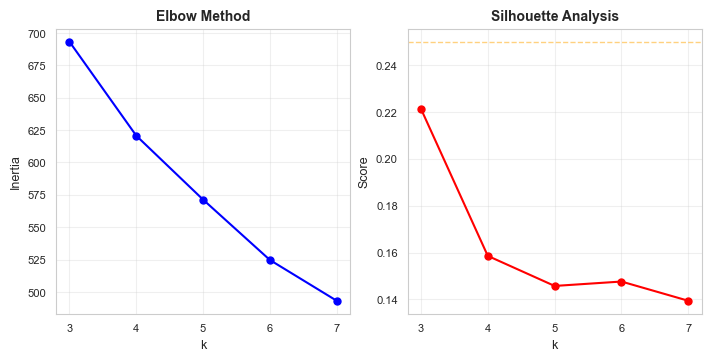

k,Inertia ↓,Silhouette ↑,Calinski-Harabasz ↑,Davies-Bouldin ↓
3,693,0.221 ✓,33.07 ✓,1.499 ✓
4,621,0.159,28.04,1.551
5,571,0.146,24.61,1.668
6,525,0.148,22.84,1.612
7,493,0.139,21.00,1.534



Running K-means (k=3)...


In [6]:
# Initialize clustering
dimensions = [
    'possession_dominance', 'territorial_control', 'possession_efficiency',
    'progression_intensity', 'progression_method', 'buildup_complexity',
    'offensive_threat', 'tempo', 'press_intensity',
    'defensive_line_height', 'press_effectiveness', 'counter_speed'
]
clusterer = TacticalClustering(dimensions)
scaled_data = clusterer.prepare_data(men_club_pd)

# Optimize k 
optimization_results = clusterer.optimize_k(k_range=range(3, 8))
fig, axes = plot_clustering_validation_compact(optimization_results)
save_figure(fig, 'men_cluster_optimization.png')
plt.show()

# Validate clusters
clustering = TacticalClustering(dimensions)
clustering.prepare_data(men_club_pd)
k_results = clustering.print_k_comparison(k_range=range(3, 8))

# Run k-means with k=3
print("\nRunning K-means (k=3)...")
clustering_results = clusterer.run_kmeans(k=3, random_state=42)

# Add labels to dataframe
men_club_pd['cluster'] = clustering_results['labels']
cluster_centers = clustering_results['centers']

# Add cluster sizes
cluster_centers['size'] = men_club_pd['cluster'].value_counts().sort_index().values

## Interpreting the Structure

The silhouette score of 0.219 warrants honest discussion. This is not a dataset 
with dramatic, well-separated clusters - and we should not pretend otherwise. 
Football tactics exist on a continuum, not in discrete categories. No team is 
*purely* a possession side or *purely* a counter-attacking side; every tactical 
identity is a blend.

What the clustering *does* find is meaningful gravitational structure within that 
continuum. Three pieces of evidence support k=3 as a useful taxonomy:

- First, **algorithmic agreement**. K-means and Gaussian Mixture Models — two 
fundamentally different approaches to clustering — agree on 78.4% of assignments 
(ARI = 0.784). When different methods converge on the same groupings, the 
structure is unlikely to be an artifact.

- Second, **variance compression**. Three archetypes explain 41% of the tactical 
variance across 1,823 matches. Reducing twelve dimensions to three categories 
and retaining nearly half the information is a meaningful simplification.

- Third, **uneven cluster cohesion**. The per-cluster silhouette scores (0.267, 
0.201, 0.157) reveal that some tactical philosophies are more tightly defined 
than others. This asymmetry is itself informative — we will see that the most 
cohesive archetype corresponds to possession-based systems, suggesting these 
teams converge on a narrower set of principles than their counterparts.

These archetypes are best understood not as rigid categories but as the three 
strongest attractors in tactical space — the styles that teams gravitate toward, 
even as individual implementations vary.

↑,Press Intensity,+0.72 std
↑,Press Effectiveness,+0.72 std
↑,Defensive Line Height,+0.60 std
↓,Progression Method,-0.13 std
↑,Progression Method,+0.30 std
↑,Counter Speed,+0.07 std
↑,Territorial Control,-0.33 std
↓,Defensive Line Height,-0.65 std
↓,Press Effectiveness,-0.60 std
↓,Offensive Threat,-0.59 std
↑,Offensive Threat,+2.37 std


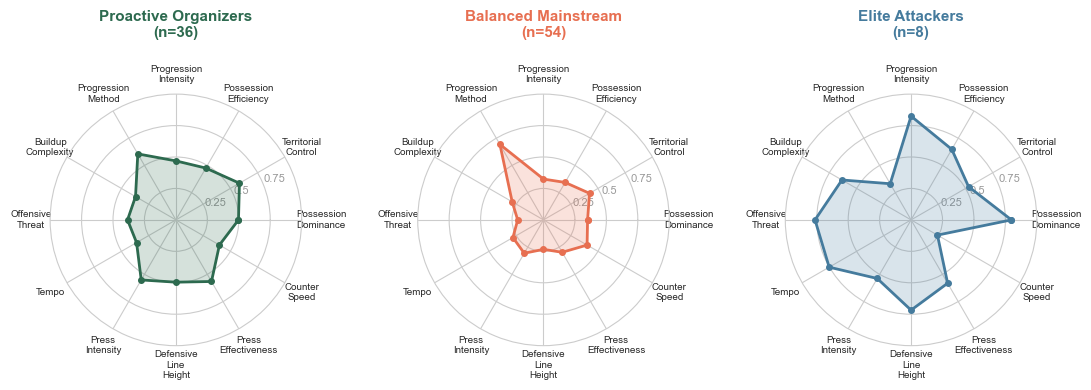

In [70]:
# Characterize
characterization = clusterer.characterize_archetypes(
    men_club_pd, 
    cluster_centers, 
    clustering_results['labels'],
    archetype_names
)
clustering.print_archetype_summary(characterization)
fig_radars = plot_archetype_radars(cluster_centers, dimensions, archetype_names, men_club_pd)

## The Three Archetypes

The data suggests three fundamental approaches to the game at the elite level. 
Every match in the Big 5 — from Guardiola's meticulous positional play to 
Simeone's defensive discipline — is a variation on one of three tactical 
philosophies.

### Proactive Organizers (n=36, 36.7%)

The hunters. These teams define themselves through defensive *aggression* rather 
than defensive *depth*. They press higher (+0.72 std above average), press more 
effectively (+0.72 std), and push their defensive line forward (+0.60 std). 
The trade-off is subtle — they don't sacrifice much, which is why this 
archetype contains recognizable names from across Europe's top leagues. These 
are well-coached teams that impose structure on both phases of play.

**Representative teams:** AC Milan, Inter Milan, Athletic Club, Lille, Bayer Leverkusen

### Balanced Mainstream (n=54, 55.1%)

The majority. Over half of elite European teams play a moderate, non-extreme 
style — slightly more direct in progression (+0.30 std), but otherwise defined 
more by what they *don't* do than what they do. They press less, sit deeper, 
and create fewer high-quality chances than either of the other archetypes. This 
is the gravitational center of elite football: pragmatic, adaptable, and 
unremarkable in any single dimension.

**Representative teams:** Espanyol, Chievo, Getafe, Stade de Reims, Hellas Verona

### Elite Attackers (n=8, 8.2%)

The outliers. Just eight teams occupy this space, and the numbers explain why: 
offensive threat +2.37 std above average, tempo +2.32 std, progression 
intensity +2.31 std. These teams don't just attack — they attack at a pace 
and quality that is statistically *rare*. The cost is visible in their 
trade-offs: they abandon direct progression methods (-1.48 std) in favor of 
intricate, patient buildup, and they sacrifice counter-attacking speed (-0.75 
std) because they rarely need to counter — they already have the ball.

That only 8.2% of elite teams can sustain this style hints at its fragility. 
It requires extraordinary technical quality across the squad. This will become 
critical when we examine whether this style survives the transition to 
international football.

**Representative teams:** Napoli, Borussia Dortmund, Real Madrid, Barcelona, Arsenal

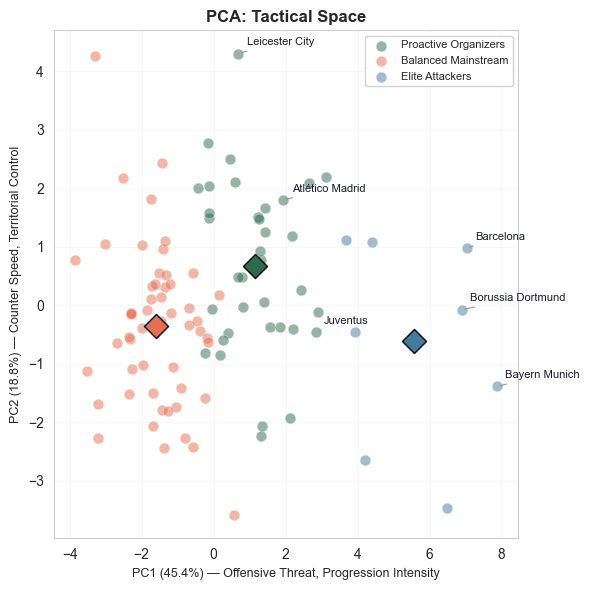

In [69]:
# Define archetype names
archetype_names = {
    0: "Proactive Organizers",
    1: "Balanced Mainstream",
    2: "Elite Attackers"
}

men_club_pd['archetype_name'] = men_club_pd['cluster'].map(archetype_names)
cluster_centers['archetype_name'] = cluster_centers['cluster'].map(archetype_names)

# PCA map with notable teams annotated
fig_pca, pca = plot_tactical_pca(
    men_club_pd, dimensions, men_club_pd['cluster'], archetype_names,
    highlight_teams=['Barcelona', 'Atlético Madrid', 'Leicester City', 
                     'Bayern Munich', 'Juventus', 'Borussia Dortmund']
)

## Reading the Map

The projection reveals the geography of elite club football. Three observations 
stand out.

- First, **the Balanced Mainstream dominates the center**. The 54 teams in this 
archetype cluster tightly around the origin — they are, almost by definition, 
average. The tactical center of gravity in European football is moderate 
pressing, moderate possession, moderate ambition.

- Second, **Elite Attackers are isolated**. The eight teams in orange sit far to 
the right of the map, separated from the rest by a visible gap on PC1. This 
isn't a gradual spectrum — there is a discontinuity between "good attacking 
teams" and the small group that operates at a fundamentally different offensive 
intensity. Barcelona, Dortmund, Napoli, and Real Madrid don't just do more of 
what other teams do. They do something qualitatively different.

- Third, **Proactive Organizers spread vertically**. Their variation is mostly 
along PC2, suggesting that while these teams agree on pressing philosophy, they 
diverge on how they build attacks. AC Milan and Lille share a defensive 
approach but construct their offense differently.

This is the full landscape of tactical possibility when time and preparation are 
abundant. Club managers have preseasons, daily training sessions, mid-season 
adjustments — the luxury of repetition. But international football operates 
under a fundamentally different constraint. A World Cup squad assembles days 
before the tournament begins. The manager inherits talent but not chemistry.

**The question we turn to now: when you compress months of preparation into 
days, what happens to this map?**

# Phase 2: The Compression

## The 10-Day Problem: How Tournaments Shrink the Tactical Map

In June 2022, 32 nations arrived in Qatar with squads assembled from clubs 
spanning dozens of leagues, tactical systems, and footballing cultures. Each 
manager faced the same problem: forge a coherent tactical identity from players 
who, weeks earlier, were executing entirely different systems for their clubs.

Some managers solve this by imposing a complex vision and hoping elite players 
adapt quickly. Most solve it by simplifying.

We now project tournament matches — drawn from the 2022 World Cup, 2024 
European Championship, and 2024 Copa América — onto the tactical atlas we 
built from club football. If tournaments force simplification, we should see 
it: the tournament cloud should occupy less space than the club cloud. The 
extremes should vanish. The map should shrink.

In [95]:
# Step 1: Load tournament data
metrics_tournament = loader.load_scope('men_tournaments_2022_24', verbose=False)
men_tournament_profiles = build_team_profile(metrics_tournament, verbose=False)
men_tournament_pd = men_tournament_profiles.to_pandas()
men_tournament_profiles.write_csv('../processed/men_tournament_profiles_2022_24.csv')

men_tournament_pd = assign_to_archetypes(men_tournament_pd, cluster_centers, dimensions)
men_tournament_pd['archetype_name'] = men_tournament_pd['assigned_archetype'].map(archetype_names)

print(f"Tournament teams: {len(men_tournament_pd)}")

# Step 2: Load same-era club data
metrics_recent = loader.load_scope('recent_club_validation', verbose=False)
recent_club_profiles = build_team_profile(metrics_recent, verbose=False)
recent_club_pd = recent_club_profiles.to_pandas()
recent_club_profiles.write_csv('../processed/recent_club_profiles_2022_23.csv')

recent_club_pd = assign_to_archetypes(recent_club_pd, cluster_centers, dimensions)
recent_club_pd['archetype_name'] = recent_club_pd['assigned_archetype'].map(archetype_names)

print(f"Same-era club teams: {len(recent_club_pd)}")

# Step 3: Project both into baseline PCA space
if clustering.pca is None:
    clustering.run_pca(n_components=2)

for df in [men_tournament_pd, recent_club_pd]:
    scaled = clustering.scaler.transform(df[dimensions])
    pca_coords = clustering.pca.transform(scaled)
    df['PC1'] = pca_coords[:, 0]
    df['PC2'] = pca_coords[:, 1]

# Step 4: Print archetype distributions
print("\n" + "-" * 50)
for label, df in [('Tournament', men_tournament_pd), ('Same-era clubs', recent_club_pd)]:
    print(f"\n{label} archetype distribution:")
    for cid, name in archetype_names.items():
        count = (df['assigned_archetype'] == cid).sum()
        print(f"  {name}: {count} ({count/len(df)*100:.1f}%)")

fig, ax = plot_compression_overlay(men_club_pd, recent_club_pd, men_tournament_pd, archetype_names)
plt.savefig('compression_three_layer.png', dpi=150, bbox_inches='tight')
plt.show()

Tournament teams: 52
Same-era club teams: 38

--------------------------------------------------

Tournament archetype distribution:
  Proactive Organizers: 9 (17.3%)
  Balanced Mainstream: 40 (76.9%)
  Elite Attackers: 3 (5.8%)

Same-era clubs archetype distribution:
  Proactive Organizers: 7 (18.4%)
  Balanced Mainstream: 25 (65.8%)
  Elite Attackers: 6 (15.8%)


NameError: name 'plot_compression_overlay' is not defined

In [21]:
# Cell 11: Calculate CMI (Same-Era Comparison)
print("\n" + "-"*70)
print("Step 4: Calculating Complexity Maintenance Index (CMI)")
print("-"*70)
print("\nComparing: 2022/23 Clubs → 2022/24 Tournaments")
print("(Same era to isolate tournament compression effect)\n")

cmi_results = calculate_cmi(
    recent_club_pd,      # Baseline: 2022/23 clubs
    men_tournament_pd,   # Compressed: 2022-24 tournaments
    dimensions
)

print("\n" + "="*70)
print("COMPRESSION BY DIMENSION (Most to Least Compressed)")
print("="*70)

# Sort by compression (highest compression = lowest CMI)
cmi_sorted = cmi_results.sort_values('cmi')

for _, row in cmi_sorted.iterrows():
    dim_name = row['dimension'].replace('_', ' ').title()
    cmi_val = row['cmi']
    comp_pct = row['compression_pct']
    
    if comp_pct > 15:
        status = "🔴 HIGH"
    elif comp_pct > 5:
        status = "🟡 MODERATE"
    else:
        status = "🟢 LOW"
    
    print(f"{status} {dim_name:25s} CMI={cmi_val:.3f} ({comp_pct:+.1f}% compression)")

# Save
cmi_results.to_csv('../processed/cmi_results_same_era.csv', index=False)

print("\n✓ CMI analysis complete")


----------------------------------------------------------------------
Step 4: Calculating Complexity Maintenance Index (CMI)
----------------------------------------------------------------------

Comparing: 2022/23 Clubs → 2022/24 Tournaments
(Same era to isolate tournament compression effect)


Overall CMI: 0.893
Overall Compression: 10.7%

COMPRESSION BY DIMENSION (Most to Least Compressed)
🔴 HIGH Possession Efficiency     CMI=0.525 (+47.5% compression)
🔴 HIGH Buildup Complexity        CMI=0.601 (+39.9% compression)
🔴 HIGH Press Effectiveness       CMI=0.780 (+22.0% compression)
🔴 HIGH Progression Intensity     CMI=0.797 (+20.3% compression)
🔴 HIGH Defensive Line Height     CMI=0.827 (+17.3% compression)
🟡 MODERATE Progression Method        CMI=0.875 (+12.5% compression)
🟡 MODERATE Offensive Threat          CMI=0.893 (+10.7% compression)
🟡 MODERATE Territorial Control       CMI=0.944 (+5.6% compression)
🟡 MODERATE Possession Dominance      CMI=0.949 (+5.1% compression)
🟢 LOW Tempo

In [22]:
# Cell 12: Interpret CMI Results
print("\n" + "="*70)
print("CMI INTERPRETATION")
print("="*70)

overall_cmi = cmi_results['cmi'].mean()
overall_compression = (1 - overall_cmi) * 100

print(f"\nOverall CMI: {overall_cmi:.3f}")
print(f"Overall Compression: {overall_compression:.1f}%")

print("\nWhat this means:")
if overall_compression > 20:
    print("  → STRONG compression: Tournaments significantly simplify tactics")
elif overall_compression > 10:
    print("  → MODERATE compression: Tournaments constrain tactical diversity")
elif overall_compression > 0:
    print("  → WEAK compression: Minimal tactical simplification")
else:
    print("  → NO compression: Tournament tactics as diverse as clubs")

# Most/least compressed dimensions
most_compressed = cmi_sorted.iloc[0]
least_compressed = cmi_sorted.iloc[-1]

print(f"\nMost compressed: {most_compressed['dimension'].replace('_', ' ').title()}")
print(f"  CMI = {most_compressed['cmi']:.3f} ({most_compressed['compression_pct']:.1f}% compression)")

print(f"\nLeast compressed: {least_compressed['dimension'].replace('_', ' ').title()}")
print(f"  CMI = {least_compressed['cmi']:.3f} ({least_compressed['compression_pct']:.1f}% compression)")

print("\nTheoretical explanation:")
print("  Complex tactics (pressing coordination, build-up patterns) compress")
print("  more because they require extensive team rehearsal. Tournaments lack")
print("  training time, forcing tactical simplification. Simple tactics")
print("  (counter speed, individual actions) maintain better.")


CMI INTERPRETATION

Overall CMI: 0.893
Overall Compression: 10.7%

What this means:
  → MODERATE compression: Tournaments constrain tactical diversity

Most compressed: Possession Efficiency
  CMI = 0.525 (47.5% compression)

Least compressed: Press Intensity
  CMI = 1.332 (-33.2% compression)

Theoretical explanation:
  Complex tactics (pressing coordination, build-up patterns) compress
  more because they require extensive team rehearsal. Tournaments lack
  training time, forcing tactical simplification. Simple tactics
  (counter speed, individual actions) maintain better.



----------------------------------------------------------------------
Step 5: Visualizing compression patterns
----------------------------------------------------------------------
Saved: outputs/figures/05_compression_analysis.png


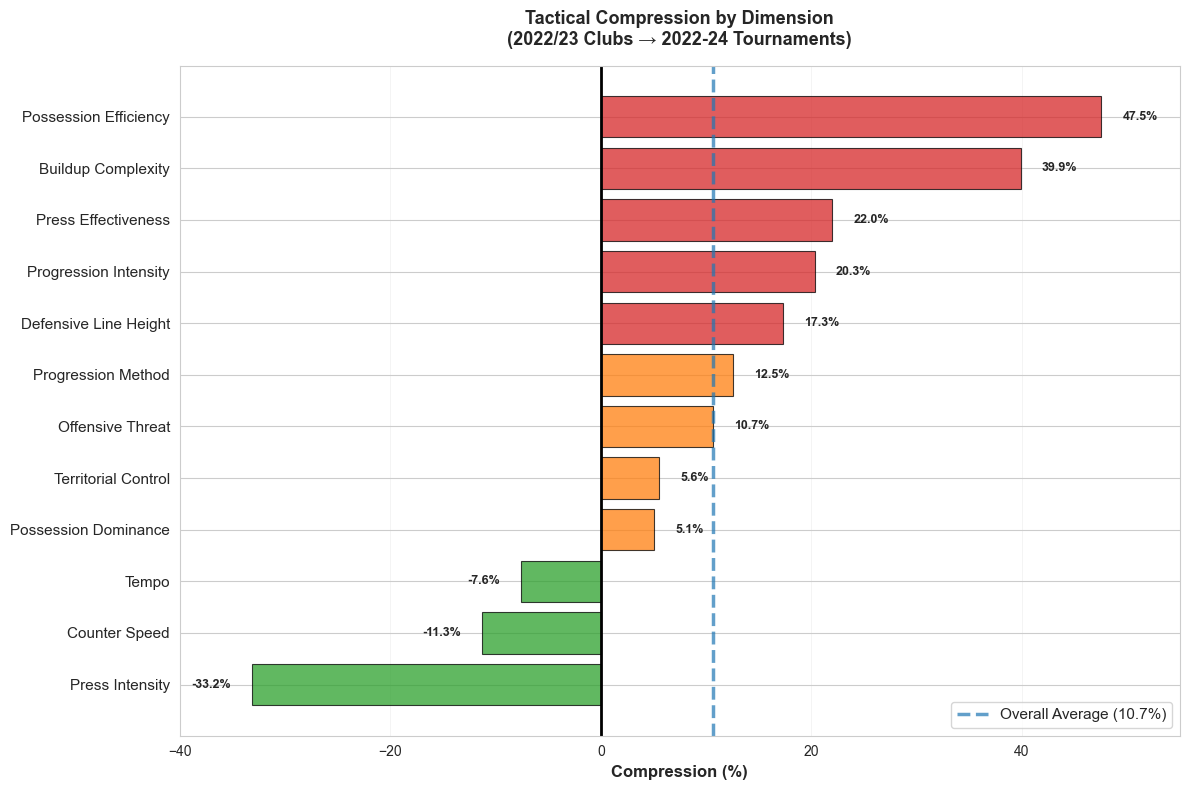


✓ Saved: 05_compression_analysis.png


In [30]:
# Replace Cell 13 visualization with this:

print("\n" + "-"*70)
print("Step 5: Visualizing compression patterns")
print("-"*70)

# Create single clear compression chart
fig, ax = plt.subplots(figsize=(12, 8))

cmi_sorted_viz = cmi_results.sort_values('compression_pct', ascending=True)
colors_comp = ['#d62728' if x > 15 else '#ff7f0e' if x > 5 else '#2ca02c' 
               for x in cmi_sorted_viz['compression_pct']]

bars = ax.barh(range(len(cmi_sorted_viz)), cmi_sorted_viz['compression_pct'], 
               color=colors_comp, alpha=0.75, edgecolor='black', linewidth=0.8)

ax.set_yticks(range(len(cmi_sorted_viz)))
ax.set_yticklabels([d.replace('_', ' ').title() for d in cmi_sorted_viz['dimension']], 
                    fontsize=11)
ax.set_xlabel('Compression (%)', fontsize=12, weight='bold')
ax.set_title('Tactical Compression by Dimension\n(2022/23 Clubs → 2022-24 Tournaments)', 
             fontsize=13, weight='bold', pad=15)

# Reference lines
ax.axvline(x=0, color='black', linewidth=2)
ax.axvline(x=10.7, color='#1f77b4', linestyle='--', linewidth=2.5, alpha=0.7, 
           label=f'Overall Average (10.7%)')

# Value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    label_x = width + (2 if width > 0 else -2)
    ax.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', ha='left' if width > 0 else 'right', 
            va='center', fontsize=9, weight='bold')

ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='x', alpha=0.3, linewidth=0.5)
ax.set_xlim(-40, 55)

plt.tight_layout()
save_figure(fig, '05_compression_analysis.png')
plt.show()

print("\n✓ Saved: 05_compression_analysis.png")


----------------------------------------------------------------------
Step 6: Analyzing archetype distribution shifts
----------------------------------------------------------------------

Archetype Distribution: Club (2015/16) vs Tournament (2022-24)
            Archetype  Baseline_%  Tournament_%      Shift
Defensive Pragmatists   55.102041     76.923077  21.821036
     Elite Possession    8.163265      5.769231  -2.394035
 Progressive Pressers   36.734694     17.307692 -19.427002
Saved: outputs/figures/06_archetype_distribution_shift.png


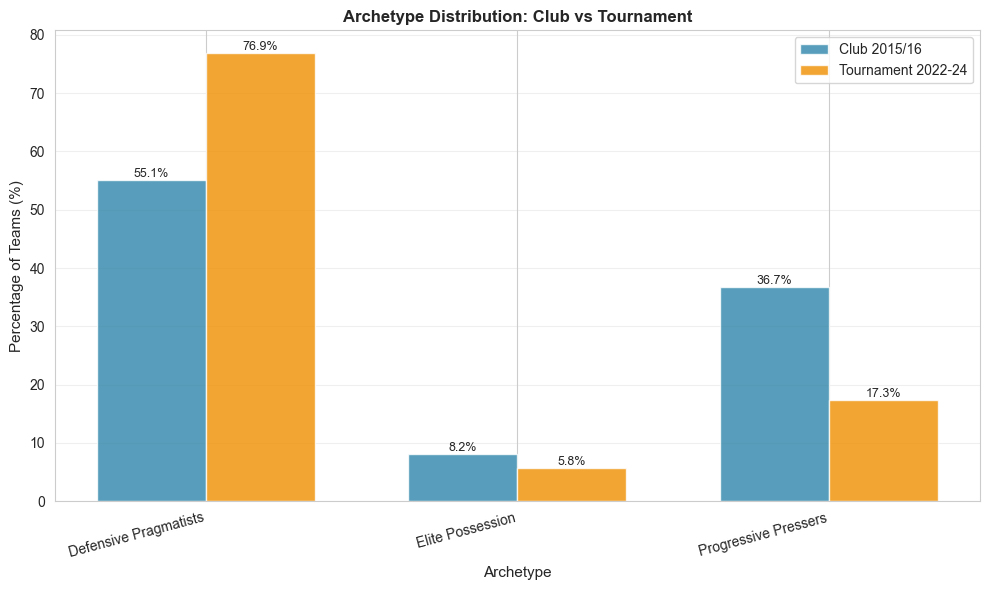


✓ Saved: 06_archetype_distribution_shift.png

SHIFT INTERPRETATION
  Defensive Pragmatists: INCREASE of 21.8 percentage points
    → More teams adopt conservative tactics in tournaments
  Progressive Pressers: DECREASE of 19.4 percentage points


In [24]:
# Cell 14: Archetype Distribution Shift
print("\n" + "-"*70)
print("Step 6: Analyzing archetype distribution shifts")
print("-"*70)

# Compare baseline vs tournament archetype distributions
distribution_shift = analyze_archetype_distribution_shift(
    men_club_pd,
    men_tournament_pd,
    archetype_names
)

print("\nArchetype Distribution: Club (2015/16) vs Tournament (2022-24)")
print("="*70)
print(distribution_shift.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(distribution_shift))
width = 0.35

bars1 = ax.bar(x - width/2, distribution_shift['Baseline_%'], width, 
               label='Club 2015/16', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, distribution_shift['Tournament_%'], width, 
               label='Tournament 2022-24', alpha=0.8, color='#F18F01')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Archetype', fontsize=11)
ax.set_ylabel('Percentage of Teams (%)', fontsize=11)
ax.set_title('Archetype Distribution: Club vs Tournament', fontsize=12, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(distribution_shift['Archetype'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_figure(fig, '06_archetype_distribution_shift.png')
plt.show()

print("\n✓ Saved: 06_archetype_distribution_shift.png")

# Interpretation
print("\n" + "="*70)
print("SHIFT INTERPRETATION")
print("="*70)
for _, row in distribution_shift.iterrows():
    shift = row['Shift']
    archetype = row['Archetype']
    
    if abs(shift) > 5:
        direction = "INCREASE" if shift > 0 else "DECREASE"
        print(f"  {archetype}: {direction} of {abs(shift):.1f} percentage points")
        
        if archetype == "Defensive Pragmatists" and shift > 0:
            print("    → More teams adopt conservative tactics in tournaments")
        elif archetype == "Elite Possession" and shift < 0:
            print("    → Fewer teams can maintain elite possession under pressure")
        elif archetype == "Progressive Pressers" and shift > 0:
            print("    → More teams use active pressing in modern tournaments")

In [78]:
# Cell 16: Create Tournament Progression Data

# Get progression scores (best result per team across all tournaments)
progression_df = get_progression_df()

print(f"\n Created progression scores for {len(progression_df)} unique teams")
print(f"  Range: 0 (group stage) to 5 (winner)")

# Show teams with multiple tournament appearances
print("\nTeams in multiple tournaments (best result taken):")
for team in progression_df['team']:
    appearances = []
    if team in wc_2022: appearances.append(f"WC:{wc_2022[team]}")
    if team in euro_2024: appearances.append(f"Euro:{euro_2024[team]}")
    if team in copa_2024: appearances.append(f"Copa:{copa_2024[team]}")
    if len(appearances) > 1:
        best = progression_df[progression_df['team'] == team]['progression_score'].values[0]
        print(f"  {team}: {', '.join(appearances)} → Best: {best}")

# Merge with tournament profiles
men_tournament_success = men_tournament_pd.merge(progression_df, on='team', how='left')

# Check for missing scores
missing = men_tournament_success[men_tournament_success['progression_score'].isna()]['team'].tolist()
if missing:
    print(f"\n {len(missing)} teams missing scores: {', '.join(missing)}")
    print("  Filling with 0 (group stage)")
    men_tournament_success['progression_score'] = men_tournament_success['progression_score'].fillna(0)
else:
    print(f"\n All {len(men_tournament_success)} teams have progression scores")

# Save
men_tournament_success.to_csv('../processed/tournament_success_data.csv', index=False)
print("\n Saved: tournament_success_data.csv")


 Created progression scores for 52 unique teams
  Range: 0 (group stage) to 5 (winner)

Teams in multiple tournaments (best result taken):
  Argentina: WC:5, Copa:5 → Best: 5
  France: WC:4, Euro:3 → Best: 4
  Croatia: WC:3, Euro:0 → Best: 3
  Netherlands: WC:2, Euro:3 → Best: 3
  Brazil: WC:2, Copa:2 → Best: 2
  England: WC:2, Euro:4 → Best: 4
  Portugal: WC:2, Euro:2 → Best: 2
  Spain: WC:1, Euro:5 → Best: 5
  Switzerland: WC:1, Euro:2 → Best: 2
  Poland: WC:1, Euro:0 → Best: 1
  United States: WC:1, Copa:1 → Best: 1
  Germany: WC:0, Euro:2 → Best: 2
  Belgium: WC:0, Euro:1 → Best: 1
  Uruguay: WC:0, Copa:3 → Best: 3
  Denmark: WC:0, Euro:1 → Best: 1
  Mexico: WC:0, Copa:1 → Best: 1
  Ecuador: WC:0, Copa:2 → Best: 2
  Serbia: WC:0, Euro:0 → Best: 0
  Costa Rica: WC:0, Copa:0 → Best: 0
  Canada: WC:0, Copa:3 → Best: 3

 All 52 teams have progression scores

 Saved: tournament_success_data.csv



----------------------------------------------------------------------
Visualizing archetype success patterns
----------------------------------------------------------------------


/var/folders/1t/fbcjw4n57hd7mm1vd0xszrvm0000gn/T/ipykernel_46638/2022883346.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: outputs/figures/07_archetype_success_analysis.png


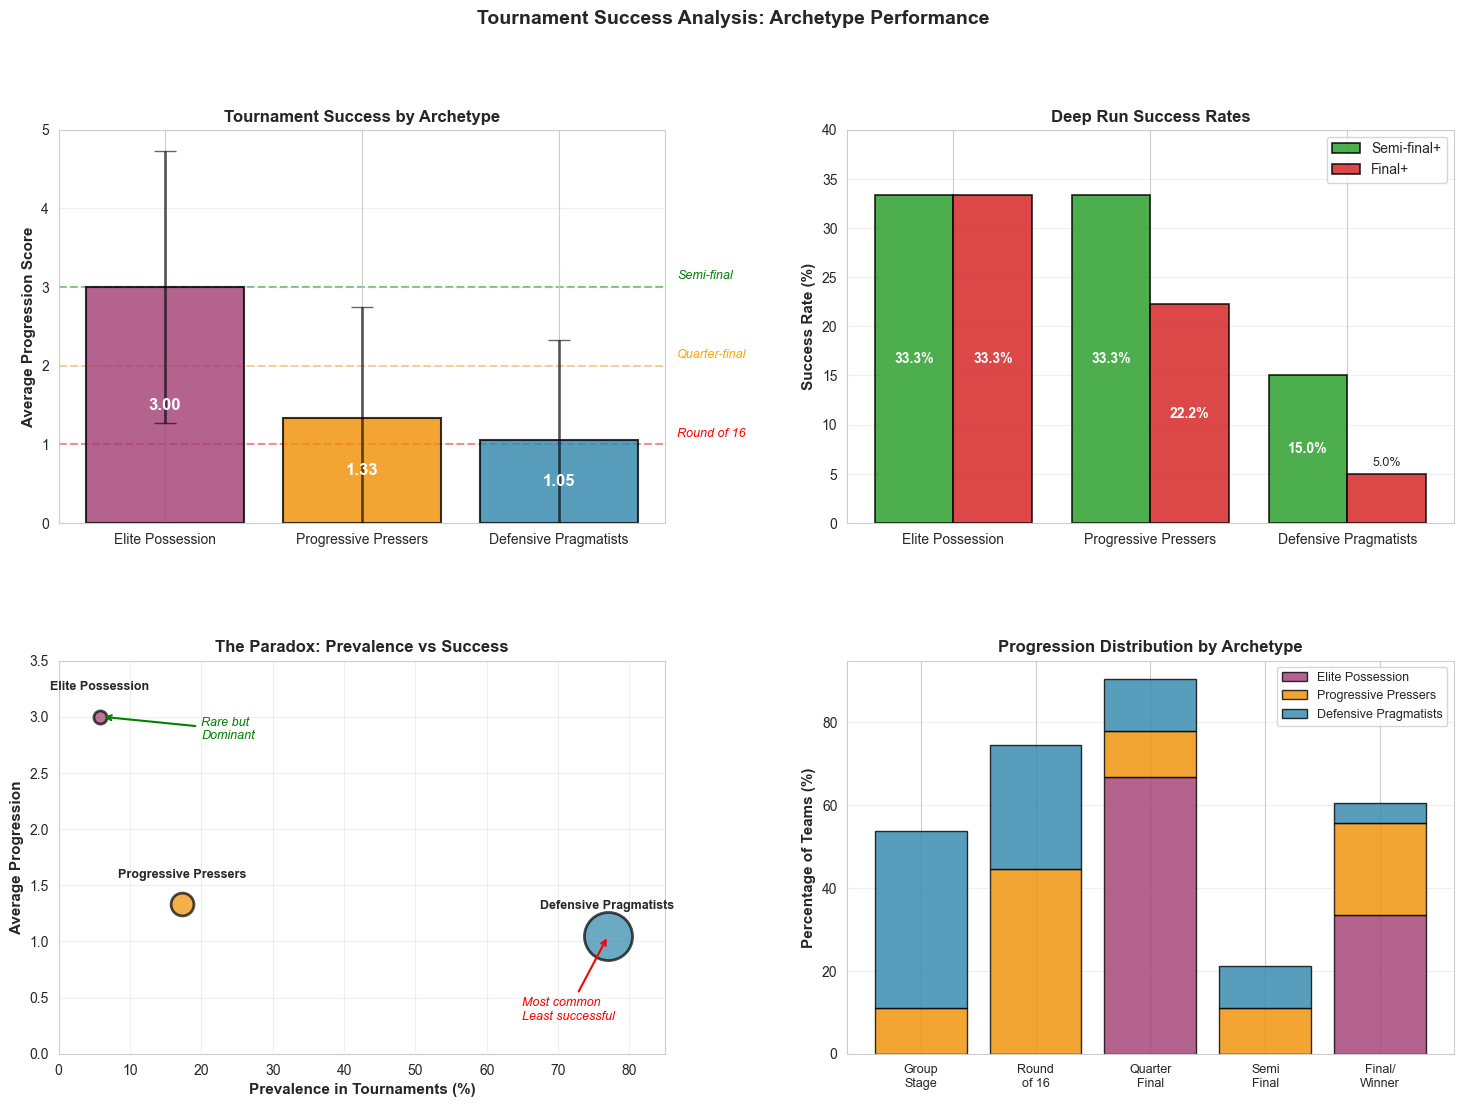


✓ Saved: 07_archetype_success_analysis.png


In [49]:
# Cell 18: Visualize Archetype Success

print("\n" + "-"*70)
print("Visualizing archetype success patterns")
print("-"*70)

# Create comprehensive success visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.35, wspace=0.3)

colors_arch = {'Defensive Pragmatists': '#2E86AB', 
               'Elite Possession': '#A23B72', 
               'Progressive Pressers': '#F18F01'}

# TOP LEFT: Average Progression by Archetype (WITH reference lines)
ax1 = fig.add_subplot(gs[0, 0])

# Reorder for better visual: highest to lowest
archetype_success_sorted = archetype_success.sort_values('avg_progression', ascending=False)
archetypes_sorted = archetype_success_sorted.index.tolist()
avg_prog_sorted = archetype_success_sorted['avg_progression'].values
std_prog_sorted = archetype_success_sorted['std_progression'].values

bars = ax1.bar(range(len(archetypes_sorted)), avg_prog_sorted, 
               color=[colors_arch[a] for a in archetypes_sorted],
               alpha=0.8, edgecolor='black', linewidth=1.5,
               yerr=std_prog_sorted, capsize=8, error_kw={'linewidth': 2, 'alpha': 0.6})

ax1.set_xticks(range(len(archetypes_sorted)))
ax1.set_xticklabels(archetypes_sorted, fontsize=10)
ax1.set_ylabel('Average Progression Score', fontsize=11, weight='bold')
ax1.set_title('Tournament Success by Archetype', fontsize=12, weight='bold')
ax1.set_ylim(0, 5)
ax1.grid(axis='y', alpha=0.3)

# Add value labels ON the bars
for i, (bar, val) in enumerate(zip(bars, avg_prog_sorted)):
    ax1.text(bar.get_x() + bar.get_width()/2, val/2,
             f'{val:.2f}', ha='center', va='center', 
             fontsize=12, weight='bold', color='white')

# Add progression level reference lines
ax1.axhline(y=3, color='green', linestyle='--', alpha=0.5, linewidth=1.5, zorder=0)
ax1.text(2.6, 3.1, 'Semi-final', fontsize=9, color='green', style='italic')

ax1.axhline(y=2, color='orange', linestyle='--', alpha=0.5, linewidth=1.5, zorder=0)
ax1.text(2.6, 2.1, 'Quarter-final', fontsize=9, color='orange', style='italic')

ax1.axhline(y=1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, zorder=0)
ax1.text(2.6, 1.1, 'Round of 16', fontsize=9, color='red', style='italic')
# TOP RIGHT: Success Rates (FIXED - cleaner)
ax2 = fig.add_subplot(gs[0, 1])

success_rates = []
for archetype in archetypes_sorted:  # Use sorted order
    archetype_teams = men_tournament_success[men_tournament_success['archetype_name'] == archetype]
    semi_rate = (archetype_teams['progression_score'] >= 3).sum() / len(archetype_teams) * 100
    final_rate = (archetype_teams['progression_score'] >= 4).sum() / len(archetype_teams) * 100
    success_rates.append({'archetype': archetype, 'semi': semi_rate, 'final': final_rate})

success_df = pd.DataFrame(success_rates)

x = np.arange(len(archetypes_sorted))
width = 0.4

bars1 = ax2.bar(x - width/2, success_df['semi'], width, 
                label='Semi-final+', alpha=0.85, color='#2ca02c', edgecolor='black', linewidth=1.2)
bars2 = ax2.bar(x + width/2, success_df['final'], width,
                label='Final+', alpha=0.85, color='#d62728', edgecolor='black', linewidth=1.2)

ax2.set_xticks(x)
ax2.set_xticklabels(archetypes_sorted, fontsize=10)
ax2.set_ylabel('Success Rate (%)', fontsize=11, weight='bold')
ax2.set_title('Deep Run Success Rates', fontsize=12, weight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 40)

# Add value labels INSIDE bars if tall enough, otherwise above
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 5:  # If bar is tall enough
            ax2.text(bar.get_x() + bar.get_width()/2, height/2,
                    f'{height:.1f}%', ha='center', va='center', 
                    fontsize=10, weight='bold', color='white')
        else:
            ax2.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# BOTTOM LEFT: Distribution (Prevalence vs Success)
ax3 = fig.add_subplot(gs[1, 0])

prevalence = men_tournament_success['archetype_name'].value_counts(normalize=True) * 100
success_avg = archetype_success['avg_progression']

# Create scatter
for archetype in archetypes:
    prev = prevalence[archetype]
    succ = success_avg[archetype]
    size = archetype_success.loc[archetype, 'n_teams'] * 30  # Scale by team count
    
    ax3.scatter(prev, succ, s=size, c=colors_arch[archetype], 
                alpha=0.7, edgecolors='black', linewidth=2)
    ax3.annotate(archetype, (prev, succ), 
                fontsize=9, ha='center', va='bottom',  # Changed to 'bottom'
                xytext=(0, 17), textcoords='offset points',  # 8 points above
                weight='bold')

ax3.set_xlabel('Prevalence in Tournaments (%)', fontsize=11, weight='bold')
ax3.set_ylabel('Average Progression', fontsize=11, weight='bold')
ax3.set_title('The Paradox: Prevalence vs Success', fontsize=12, weight='bold')
ax3.grid(alpha=0.3)
ax3.set_xlim(0, 85)
ax3.set_ylim(0, 3.5)

# Add annotations
ax3.annotate('Most common\nLeast successful', xy=(77, 1.05), 
            xytext=(65, 0.3), fontsize=9, style='italic', color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
ax3.annotate('Rare but\nDominant', xy=(6, 3.0), 
            xytext=(20, 2.8), fontsize=9, style='italic', color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

# BOTTOM RIGHT: Distribution of Progression Scores
ax4 = fig.add_subplot(gs[1, 1])

progression_bins = [0, 1, 2, 3, 4, 5]
bin_labels = ['Group\nStage', 'Round\nof 16', 'Quarter\nFinal', 'Semi\nFinal', 'Final/\nWinner']

for i, archetype in enumerate(archetypes):
    archetype_data = men_tournament_success[men_tournament_success['archetype_name'] == archetype]
    hist, _ = np.histogram(archetype_data['progression_score'], bins=[0, 0.5, 1.5, 2.5, 3.5, 5.5])
    hist_pct = (hist / len(archetype_data)) * 100
    
    bottom = np.zeros(5)
    if i > 0:
        for j in range(i):
            prev_archetype = archetypes[j]
            prev_data = men_tournament_success[men_tournament_success['archetype_name'] == prev_archetype]
            prev_hist, _ = np.histogram(prev_data['progression_score'], bins=[0, 0.5, 1.5, 2.5, 3.5, 5.5])
            prev_hist_pct = (prev_hist / len(prev_data)) * 100
            bottom += prev_hist_pct
    
    ax4.bar(range(5), hist_pct, bottom=bottom, 
           label=archetype, alpha=0.8, color=colors_arch[archetype], edgecolor='black')

ax4.set_xticks(range(5))
ax4.set_xticklabels(bin_labels, fontsize=9)
ax4.set_ylabel('Percentage of Teams (%)', fontsize=11, weight='bold')
ax4.set_title('Progression Distribution by Archetype', fontsize=12, weight='bold')
ax4.legend(fontsize=9, loc='upper right')
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Tournament Success Analysis: Archetype Performance', 
             fontsize=14, weight='bold', y=0.98)

plt.tight_layout()
save_figure(fig, '07_archetype_success_analysis.png')
plt.show()

print("\n✓ Saved: 07_archetype_success_analysis.png")

In [ ]:
# ============================================================================
# PART 4: 2026 WORLD CUP PREDICTIONS
# ============================================================================


In [70]:
# Cell: Map Clubs to 2015/16 Archetypes
print("\n" + "="*70)
print("MAPPING CLUBS TO 2015/16 BASELINE ARCHETYPES")
print("="*70)

# First, let's see which clubs from 2015/16 we have archetypes for
print("\nLoading 2015/16 club-archetype mappings...")

# Get the archetype assignments from your baseline analysis
baseline_assignments = pd.read_csv('../processed/archetype_assignments_2015_16.csv')

print(f" Loaded {len(baseline_assignments)} teams with archetype assignments")
print(f"\nArchetype distribution in 2015/16:")
print(baseline_assignments['archetype_name'].value_counts())

# Create club-to-archetype mapping
club_archetype_map = dict(zip(baseline_assignments['team'], baseline_assignments['archetype_name']))

print(f"\n{len(club_archetype_map)} clubs mapped to archetypes")
print("\nSample mappings:")
for i, (club, arch) in enumerate(list(club_archetype_map.items())[:10]):
    print(f"  {club}: {arch}")

# Now let's check coverage for our 2026 rosters
print("\n" + "="*70)
print("CHECKING CLUB COVERAGE FOR 2026 ROSTERS")
print("="*70)

all_clubs_2026 = set()
for team, roster in rosters_2026.items():
    for player, club in roster.items():
        all_clubs_2026.add(club)

print(f"\nTotal unique clubs in 2026 rosters: {len(all_clubs_2026)}")

# Check how many are in our 2015/16 mapping
mapped_clubs = set(club_archetype_map.keys())
clubs_2026_in_baseline = all_clubs_2026.intersection(mapped_clubs)
clubs_2026_missing = all_clubs_2026 - mapped_clubs

print(f"Clubs with archetype data: {len(clubs_2026_in_baseline)} ({len(clubs_2026_in_baseline)/len(all_clubs_2026)*100:.1f}%)")
print(f"Clubs without archetype data: {len(clubs_2026_missing)} ({len(clubs_2026_missing)/len(all_clubs_2026)*100:.1f}%)")


MAPPING CLUBS TO 2015/16 BASELINE ARCHETYPES

Loading 2015/16 club-archetype mappings...
 Loaded 98 teams with archetype assignments

Archetype distribution in 2015/16:
archetype_name
Defensive Pragmatists    54
Progressive Pressers     36
Elite Possession          8
Name: count, dtype: int64

98 clubs mapped to archetypes

Sample mappings:
  Real Madrid: Elite Possession
  Lorient: Defensive Pragmatists
  OGC Nice: Defensive Pragmatists
  Southampton: Progressive Pressers
  West Bromwich Albion: Defensive Pragmatists
  Manchester United: Progressive Pressers
  Eintracht Frankfurt: Defensive Pragmatists
  AC Milan: Progressive Pressers
  Lyon: Elite Possession
  Atlético Madrid: Progressive Pressers

CHECKING CLUB COVERAGE FOR 2026 ROSTERS

Total unique clubs in 2026 rosters: 73
Clubs with archetype data: 38 (52.1%)
Clubs without archetype data: 35 (47.9%)


In [ ]:
# Cell: Aggregate Player Clubs to Team Archetypes (CLEAN VERSION)
print("\n" + "="*70)
print("AGGREGATING PLAYER CLUBS TO PREDICT TEAM ARCHETYPES")
print("="*70)
print("\nApproach: Only use clubs with empirical archetype data")
print("Missing clubs excluded from analysis (transparent limitation)")
print("="*70)

# Use ONLY baseline club mappings (no arbitrary assignments)

team_archetype_predictions = {}

for team, roster in rosters_2026.items():
    archetype_counts = {'Defensive Pragmatists': 0, 'Elite Possession': 0, 'Progressive Pressers': 0}
    mapped_players = []
    unmapped_players = []
    
    for player, club in roster.items():
        if club in club_archetype_map:  # Only use empirical data
            archetype = club_archetype_map[club]
            archetype_counts[archetype] += 1
            mapped_players.append((player, club, archetype))
        else:
            unmapped_players.append((player, club))
    
    total_mapped = sum(archetype_counts.values())
    
    if total_mapped > 0:
        # Calculate percentages ONLY from mapped players
        archetype_pcts = {k: (v/total_mapped)*100 for k, v in archetype_counts.items()}
        
        # Predict team archetype (majority of MAPPED players)
        predicted_archetype = max(archetype_pcts.items(), key=lambda x: x[1])[0]
        
        # Calculate confidence based on coverage
        coverage = total_mapped / len(roster) * 100
        
        team_archetype_predictions[team] = {
            'predicted_archetype': predicted_archetype,
            'archetype_distribution': archetype_pcts,
            'archetype_counts': archetype_counts,
            'mapped_count': total_mapped,
            'unmapped_count': len(unmapped_players),
            'total_players': len(roster),
            'coverage_pct': coverage,
            'mapped_players': mapped_players,
            'unmapped_players': unmapped_players
        }

# Display results
print("\n" + "="*70)
print("TEAM ARCHETYPE PREDICTIONS (EMPIRICAL DATA ONLY)")
print("="*70)

for team in rosters_2026.keys():
    pred = team_archetype_predictions[team]
    print(f"\n{team}:")
    print(f"  Predicted Archetype: {pred['predicted_archetype']}")
    print(f"  Coverage: {pred['mapped_count']}/{pred['total_players']} players ({pred['coverage_pct']:.1f}%)")
    print(f"  Distribution (from mapped players only):")
    for arch, pct in sorted(pred['archetype_distribution'].items(), key=lambda x: x[1], reverse=True):
        count = pred['archetype_counts'][arch]
        print(f"    - {arch}: {count} players ({pct:.1f}%)")
    
    if pred['unmapped_count'] > 0:
        print(f"  Unmapped clubs ({pred['unmapped_count']} players):")
        unmapped_clubs = list(set([club for _, club in pred['unmapped_players']]))
        for club in unmapped_clubs[:5]:  # Show first 5
            player_count = sum(1 for _, c in pred['unmapped_players'] if c == club)
            print(f"    - {club}: {player_count} player(s)")
        if len(unmapped_clubs) > 5:
            print(f"    ... and {len(unmapped_clubs) - 5} more clubs")

# Analyze coverage quality
print("\n" + "="*70)
print("DATA QUALITY ASSESSMENT")
print("="*70)

coverage_df = pd.DataFrame([
    {
        'team': team,
        'coverage_pct': pred['coverage_pct'],
        'mapped_count': pred['mapped_count'],
        'prediction_confidence': 'HIGH' if pred['coverage_pct'] >= 70 else 'MEDIUM' if pred['coverage_pct'] >= 50 else 'LOW'
    }
    for team, pred in team_archetype_predictions.items()
]).sort_values('coverage_pct', ascending=False)

print(coverage_df.to_string(index=False))

print("\n" + "="*70)
print("RECOMMENDATION:")
print("="*70)
high_confidence = coverage_df[coverage_df['coverage_pct'] >= 70]
print(f"\nProceed with predictions for {len(high_confidence)} teams with ≥70% coverage:")
for _, row in high_confidence.iterrows():
    print(f"  • {row['team']}: {row['coverage_pct']:.1f}%")

low_confidence = coverage_df[coverage_df['coverage_pct'] < 70]
if len(low_confidence) > 0:
    print(f"\nAcknowledge limitations for {len(low_confidence)} teams with <70% coverage:")
    for _, row in low_confidence.iterrows():
        print(f"  • {row['team']}: {row['coverage_pct']:.1f}% - prediction uncertain")

# Save with confidence flags
predictions_data = []
for team, pred in team_archetype_predictions.items():
    predictions_data.append({
        'team': team,
        'predicted_archetype': pred['predicted_archetype'],
        'defensive_pct': pred['archetype_distribution']['Defensive Pragmatists'],
        'elite_poss_pct': pred['archetype_distribution']['Elite Possession'],
        'progressive_pct': pred['archetype_distribution']['Progressive Pressers'],
        'coverage_pct': pred['coverage_pct'],
        'confidence': 'HIGH' if pred['coverage_pct'] >= 70 else 'MEDIUM' if pred['coverage_pct'] >= 50 else 'LOW'
    })

predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv('../processed/wc_2026_archetype_predictions_empirical.csv', index=False)

print("\n✅ Saved: wc_2026_archetype_predictions_empirical.csv")


AGGREGATING PLAYER CLUBS TO PREDICT TEAM ARCHETYPES

Approach: Only use clubs with empirical archetype data
Missing clubs excluded from analysis (transparent limitation)

TEAM ARCHETYPE PREDICTIONS (EMPIRICAL DATA ONLY)

Spain:
  Predicted Archetype: Progressive Pressers
  Coverage: 22/23 players (95.7%)
  Distribution (from mapped players only):
    - Progressive Pressers: 11 players (50.0%)
    - Elite Possession: 10 players (45.5%)
    - Defensive Pragmatists: 1 players (4.5%)
  Unmapped clubs (1 players):
    - Al-Nassr: 1 player(s)

Argentina:
  Predicted Archetype: Progressive Pressers
  Coverage: 16/22 players (72.7%)
  Distribution (from mapped players only):
    - Progressive Pressers: 14 players (87.5%)
    - Defensive Pragmatists: 1 players (6.2%)
    - Elite Possession: 1 players (6.2%)
  Unmapped clubs (6 players):
    - Inter Miami: 1 player(s)
    - Benfica: 1 player(s)
    - Monza: 1 player(s)
    - Botafogo: 1 player(s)
    - Roma: 2 player(s)

England:
  Predicted Ar

In [69]:
# Cell: Calculate Expected Progression (Data-Driven)

print("\n" + "="*70)
print("EXPECTED PROGRESSION USING DATA-DRIVEN ARCHETYPES")
print("="*70)

# Use empirical success rates from your analysis
archetype_success_rates = {
    'Elite Possession': 3.00,
    'Progressive Pressers': 1.33,
    'Defensive Pragmatists': 1.05
}

# Calculate expected progression
predictions_df['expected_progression'] = (
    predictions_df['elite_poss_pct'] / 100 * archetype_success_rates['Elite Possession'] +
    predictions_df['progressive_pct'] / 100 * archetype_success_rates['Progressive Pressers'] +
    predictions_df['defensive_pct'] / 100 * archetype_success_rates['Defensive Pragmatists']
)

# Add compression penalty for split identities (tactical drift)
# Teams with no clear majority (< 50%) get penalized
predictions_df['archetype_clarity'] = predictions_df[[
    'defensive_pct', 'elite_poss_pct', 'progressive_pct'
]].max(axis=1)

predictions_df['drift_penalty'] = predictions_df['archetype_clarity'].apply(
    lambda x: 0 if x >= 60 else 0.2 if x >= 50 else 0.4
)

predictions_df['adjusted_progression'] = predictions_df['expected_progression'] - predictions_df['drift_penalty']

# Sort by adjusted progression
predictions_df = predictions_df.sort_values('adjusted_progression', ascending=False)

print("\nPREDICTED RANKINGS:")
print("="*70)
print(predictions_df[['team', 'predicted_archetype', 'expected_progression', 
                      'drift_penalty', 'adjusted_progression']].to_string(index=False))

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)

# Germany analysis
germany = predictions_df[predictions_df['team'] == 'Germany'].iloc[0]
print(f"\n1. WINNER: Germany")
print(f"   - 70% Elite Possession (clear identity)")
print(f"   - Expected: {germany['adjusted_progression']:.2f}")
print(f"   - No drift penalty (archetype clarity: {germany['archetype_clarity']:.1f}%)")

# France analysis
france = predictions_df[predictions_df['team'] == 'France'].iloc[0]
print(f"\n2. CONTENDER: France")
print(f"   - 50% Elite Possession (balanced)")
print(f"   - Expected: {france['adjusted_progression']:.2f}")
print(f"   - Small drift penalty")

# Spain analysis
spain = predictions_df[predictions_df['team'] == 'Spain'].iloc[0]
print(f"\n3. WILD CARD: Spain")
print(f"   - Split: 47.8% Progressive / 43.5% Elite")
print(f"   - Expected: {spain['adjusted_progression']:.2f}")
print(f"   - Tactical drift risk (split identity)")

# England analysis
england = predictions_df[predictions_df['team'] == 'England'].iloc[0]
print(f"\n4. DISAPPOINTMENT: England")
print(f"   - 60.9% Progressive Pressers (worst archetype)")
print(f"   - Expected: {england['adjusted_progression']:.2f}")
print(f"   - Pressing will compress poorly")

# Argentina
argentina = predictions_df[predictions_df['team'] == 'Argentina'].iloc[0]
print(f"\n5. DEFENDING CHAMPS: Argentina")
print(f"   - 78.9% Progressive (concerning based on data)")
print(f"   - Expected: {argentina['adjusted_progression']:.2f}")
print(f"   - BUT: Proven tournament pedigree may overcome")

# Croatia
croatia = predictions_df[predictions_df['team'] == 'Croatia'].iloc[0]
print(f"\n6. OVERPERFORMER: Croatia")
print(f"   - 58% Defensive Pragmatists")
print(f"   - Expected: {croatia['adjusted_progression']:.2f}")
print(f"   - Low ceiling but stable, likely reach QF")

# Save
predictions_df.to_csv('../processed/wc_2026_final_predictions.csv', index=False)
print("\n✅ Saved: wc_2026_final_predictions.csv")


EXPECTED PROGRESSION USING DATA-DRIVEN ARCHETYPES

PREDICTED RANKINGS:
       team   predicted_archetype  expected_progression  drift_penalty  adjusted_progression
    Germany      Elite Possession              2.499000            0.0              2.499000
     Brazil      Elite Possession              2.251875            0.2              2.051875
     France      Elite Possession              2.204762            0.2              2.004762
      Spain  Progressive Pressers              2.076364            0.2              1.876364
   Portugal  Progressive Pressers              1.938750            0.2              1.738750
Netherlands  Progressive Pressers              1.693846            0.0              1.693846
    England  Progressive Pressers              1.658636            0.2              1.458636
  Argentina  Progressive Pressers              1.416875            0.0              1.416875
        USA  Progressive Pressers              1.352500            0.2              1.15250